#### By: Peyman Shahidi
#### Created: Aug 14, 2025

<br>

In [1]:
# step1_micro_macro_plumbing.py
# Minimal, testable scaffolding for Γ(u), Ψ(u), M,H,w,u and a cutoff residual.
# Assumes ρ ∈ (-1, 0). Starts with τM = τH = 1; can generalize easily.

from dataclasses import dataclass
import math
from typing import Tuple

@dataclass
class Params:
    beta_H: float
    beta_M: float
    theta_H: float
    theta_M: float
    rho: float                 # must be in (-1, 0)
    tau_H: float = 1.0         # fixed = 1 for step 1
    tau_M: float = 1.0         # fixed = 1 for step 1

def _validate(p: Params):
    if not (-1.0 < p.rho < 0.0):
        raise ValueError("rho must be in (-1, 0).")
    if p.theta_H <= 0 or p.theta_M <= 0 or (p.theta_H + p.theta_M) >= 1.0:
        raise ValueError("theta_H, theta_M > 0 and theta_H + theta_M < 1 (positive capital share).")
    if p.beta_H <= 0 or p.beta_M <= 0:
        raise ValueError("beta_H and beta_M must be > 0.")
    if p.tau_H <= 0 or p.tau_M <= 0:
        raise ValueError("tau_H and tau_M must be > 0.")
    # domain checks for the closed-form terms
    a = 1.0 - p.theta_H * (p.tau_H ** p.rho)
    if a <= 0:
        raise ValueError("Need 1 - theta_H * tau_H^rho > 0 for the closed-form Γ,Ψ.")
    if p.theta_M * (p.tau_M ** p.rho) <= 0:
        raise ValueError("theta_M * tau_M^rho must be > 0.")

def gamma_of_u(u: float, p: Params) -> float:
    """
    Closed-form Γ(u) from Appendix B. Valid for 0<u<1 and parameters satisfying constraints.
    """
    _validate(p)
    if not (0.0 < u < 1.0):
        raise ValueError("u must be in (0, 1).")
    k1 = (1.0 - p.theta_M - p.theta_H) ** (1.0 / p.rho)
    a = 1.0 - p.theta_H * (p.tau_H ** p.rho)
    b = a ** (p.rho / (p.rho - 1.0))
    c = (p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho))
    uexp = p.rho / (p.rho - 1.0)
    bracket = 1.0 - p.theta_H * (p.tau_H ** p.rho) - b * c * (u ** uexp)
    if bracket <= 0.0:
        # outside support -> Γ blows up; return +inf to signal infeasible u
        return math.inf
    return k1 * (bracket ** (-1.0 / p.rho))

def psi_of_u(u: float, p: Params) -> float:
    """
    Closed-form Ψ(u) using the identity Ψ(u) = K * u^{1/(rho-1)} * Γ(u),
    where K = (1 - θH τH^ρ)^{1/(ρ-1)} (θM τM^ρ)^{1/(1-ρ)}  (Appendix B, Eq. (24)).
    """
    _validate(p)
    Gamma = gamma_of_u(u, p)
    if not math.isfinite(Gamma):
        return math.inf
    K = (1.0 - p.theta_H * (p.tau_H ** p.rho)) ** (1.0 / (p.rho - 1.0)) \
        * (p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho))
    uexp = 1.0 / (p.rho - 1.0)
    return K * (u ** uexp) * Gamma

def m_over_h_from_u(u: float, p: Params) -> float:
    """
    Micro-to-macro mix identity: M/H = (τM Ψ)/(τH Γ).
    With the Ψ identity this reduces to (τM/τH) * K * u^{1/(ρ-1)}.
    """
    _validate(p)
    if not (0.0 < u < 1.0):
        raise ValueError("u must be in (0, 1).")
    K = (1.0 - p.theta_H * (p.tau_H ** p.rho)) ** (1.0 / (p.rho - 1.0)) \
        * (p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho))
    uexp = 1.0 / (p.rho - 1.0)
    return (p.tau_M / p.tau_H) * K * (u ** uexp)

def MH_from_Gamma(Gamma: float, p: Params) -> Tuple[float, float]:
    """
    H and M in terms of Γ (from equating supply/demand with S=Γ^ρ).
    H = ( (β_H/θ_H) * Γ^{1-1/ρ} )^{1/(ρ-2)}, and same for M.  (GE note, Eq. (8))
    """
    _validate(p)
    if Gamma <= 0.0 or not math.isfinite(Gamma):
        raise ValueError("Gamma must be finite and > 0.")
    power = 1.0 / (p.rho - 2.0)
    common = Gamma ** (1.0 - 1.0 / p.rho)
    H = ((p.beta_H / p.theta_H) * common) ** power
    M = ((p.beta_M / p.theta_M) * common) ** power
    return M, H

def wages_from_supply(M: float, H: float, p: Params) -> Tuple[float, float]:
    """Supply side wages (GE note Eq. (2)): wM=β_M M, wH=β_H H."""
    return (p.beta_M * M, p.beta_H * H)

def cutoff_from_wages(wM: float, wH: float, p: Params) -> float:
    """u = (wM τM) / (1 - wH τH). Requires denominator > 0 (feasible region)."""
    denom = 1.0 - wH * p.tau_H
    if denom <= 0.0:
        return math.inf
    return (wM * p.tau_M) / denom

def residual_u(u: float, p: Params) -> dict:
    """
    Diagnostic: given a guess u, compute Γ(u) → (M,H) → (wM,wH) → u_implied.
    Return a small dict with the residual and key pieces for inspection.
    """
    Gamma = gamma_of_u(u, p)
    Psi   = psi_of_u(u, p)
    M, H  = MH_from_Gamma(Gamma, p)
    wM, wH = wages_from_supply(M, H, p)
    u_implied = cutoff_from_wages(wM, wH, p)
    return {
        "u_guess": u,
        "Gamma(u)": Gamma,
        "Psi(u)": Psi,
        "M": M, "H": H,
        "wM": wM, "wH": wH,
        "u_implied": u_implied,
        "residual": u_implied - u,
        "M_over_H_micro": (p.tau_M * Psi) / (p.tau_H * Gamma),  # should match M/H in equilibrium
        "M_over_H_macro": (M / H),
        "X": Gamma,             # by consistency, output X = Γ
        "S": Gamma ** p.rho     # CES aggregator power
    }

if __name__ == "__main__":
    # Tiny smoke test with plausible values (ρ in (-1,0), cap share > 0)
    p = Params(
        beta_H=1.0, beta_M=1.0,
        theta_H=0.55, theta_M=0.35,  # leaves 0.10 for capital share
        rho=-0.5,
        tau_H=1.0, tau_M=1.0
    )
    # Try a few u guesses to see the residual sign
    for u0 in (0.20, 0.35, 0.50, 0.59, 0.65, 0.80):
        out = residual_u(u0, p)
        print({k: (round(v,5) if isinstance(v,float) and math.isfinite(v) else v)
               for k,v in out.items() if k in ("u_guess","Gamma(u)","M","H","wM","wH","u_implied","residual",
                                               "M_over_H_micro","M_over_H_macro")})

{'u_guess': 0.2, 'Gamma(u)': 5.17261, 'M': 0.09145, 'H': 0.10957, 'wM': 0.09145, 'wH': 0.10957, 'u_implied': 0.1027, 'residual': -0.0973, 'M_over_H_micro': 2.47296, 'M_over_H_macro': 0.83461}
{'u_guess': 0.35, 'Gamma(u)': 3.30482, 'M': 0.15655, 'H': 0.18757, 'wM': 0.15655, 'wH': 0.18757, 'u_implied': 0.19269, 'residual': -0.15731, 'M_over_H_micro': 1.70291, 'M_over_H_macro': 0.83461}
{'u_guess': 0.5, 'Gamma(u)': 2.18836, 'M': 0.25674, 'H': 0.30761, 'wM': 0.25674, 'wH': 0.30761, 'u_implied': 0.3708, 'residual': -0.1292, 'M_over_H_micro': 1.34253, 'M_over_H_macro': 0.83461}
{'u_guess': 0.59, 'Gamma(u)': 1.71079, 'M': 0.34498, 'H': 0.41334, 'wM': 0.34498, 'wH': 0.41334, 'u_implied': 0.58804, 'residual': -0.00196, 'M_over_H_micro': 1.20227, 'M_over_H_macro': 0.83461}
{'u_guess': 0.65, 'Gamma(u)': 1.44779, 'M': 0.42148, 'H': 0.50501, 'wM': 0.42148, 'wH': 0.50501, 'u_implied': 0.8515, 'residual': 0.2015, 'M_over_H_micro': 1.1271, 'M_over_H_macro': 0.83461}
{'u_guess': 0.8, 'Gamma(u)': 0.9350

In [2]:
# ge_step2_consistent_levels.py
# ρ ∈ (-1,0). No τ-normalization. Single equilibrium:
# (1) solve u* from micro↔macro mix,
# (2) set levels from macro FOCs (eq. 8),
# (3) scale betas by a common s so the cutoff holds at the same u*.
# Cutoff checked again via a separate fixed-point that uses (8).

from dataclasses import dataclass
import math

@dataclass
class Params:
    beta_H: float
    beta_M: float
    theta_H: float
    theta_M: float
    rho: float    # (-1,0)
    tau_H: float
    tau_M: float

# ---------- validation ----------
def _validate(p: Params):
    if not (-1.0 < p.rho < 0.0):
        raise ValueError("rho must be in (-1,0).")
    if p.theta_H <= 0 or p.theta_M <= 0 or p.theta_H + p.theta_M >= 1.0:
        raise ValueError("theta_H, theta_M > 0 and theta_H+theta_M < 1.")
    if p.beta_H <= 0 or p.beta_M <= 0 or p.tau_H <= 0 or p.tau_M <= 0:
        raise ValueError("betas and taus must be > 0.")
    if 1.0 - p.theta_H * (p.tau_H ** p.rho) <= 0.0:
        raise ValueError("Need 1 - θH τH^ρ > 0 for Γ,Ψ.")

# ---------- micro integrals Γ, Ψ (Appx. 23–24) ----------
def gamma_of_u(u: float, p: Params) -> float:
    _validate(p)
    if not (0.0 < u < 1.0):
        return math.inf
    a = 1.0 - p.theta_H * (p.tau_H ** p.rho)
    t = p.rho / (p.rho - 1.0)  # in (0,1)
    K = (a ** (p.rho / (p.rho - 1.0))) * ((p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho)))
    bracket = a - K * (u ** t)
    if bracket <= 0.0:
        return math.inf
    return ((1.0 - p.theta_M - p.theta_H) ** (1.0 / p.rho)) * (bracket ** (-1.0 / p.rho))

def psi_of_u(u: float, p: Params) -> float:
    G = gamma_of_u(u, p)
    if not math.isfinite(G): return math.inf
    a = 1.0 - p.theta_H * (p.tau_H ** p.rho)
    K1 = (a ** (1.0 / (p.rho - 1.0))) * ((p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho)))
    return K1 * (u ** (1.0 / (p.rho - 1.0))) * G

def u_support_max(p: Params) -> float:
    a = 1.0 - p.theta_H * (p.tau_H ** p.rho)
    t = p.rho / (p.rho - 1.0)
    K = (a ** (p.rho / (p.rho - 1.0))) * ((p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho)))
    rhs = a / K
    umax = rhs ** (1.0 / t) if rhs > 0 else 0.99
    return max(1e-10, min(0.999999, umax * 0.999))

# ---------- macro ratio (from (8)) & micro ratio ----------
def macro_ratio_target(p: Params) -> float:
    base = (p.beta_M / p.beta_H) * (p.theta_H / p.theta_M)
    if base <= 0: return math.inf
    return base ** (1.0 / (p.rho - 2.0))

def micro_ratio(u: float, p: Params) -> float:
    G = gamma_of_u(u, p); P = psi_of_u(u, p)
    return (p.tau_M * P) / (p.tau_H * G)

# ---------- (8): levels from Γ and betas ----------
def MH_from_Gamma_u(u: float, p: Params, beta_scale: float = 1.0):
    G = gamma_of_u(u, p)
    if not (math.isfinite(G) and G > 0): return math.inf, math.inf, G
    # S = Γ^ρ (macro)
    power = 1.0 / (p.rho - 2.0)
    common = G ** (1.0 - 1.0 / p.rho)
    H = (((beta_scale * p.beta_H) / p.theta_H) * common) ** power
    M = (((beta_scale * p.beta_M) / p.theta_M) * common) ** power
    return M, H, G

# ---------- mix solver for u ----------
def u_from_mix_closed_form(p: Params) -> float:
    R = macro_ratio_target(p)
    if not (math.isfinite(R) and R > 0): return math.inf
    a = 1.0 - p.theta_H * (p.tau_H ** p.rho)
    K1 = (a ** (1.0 / (p.rho - 1.0))) * ((p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho)))
    denom = (p.tau_M / p.tau_H) * K1
    if denom <= 0: return math.inf
    u = (R / denom) ** (p.rho - 1.0)
    return max(1e-10, min(u_support_max(p), u))

def bisection(f, lo, hi, tol=1e-12, max_iter=250):
    flo, fhi = f(lo), f(hi)
    if not (math.isfinite(flo) and math.isfinite(fhi)) or flo * fhi > 0:
        # coarse scan to bracket
        N = 400; prev_u, prev_f = lo, flo
        for i in range(1, N):
            ui = lo + (hi - lo) * i / N; fi = f(ui)
            if math.isfinite(prev_f) and math.isfinite(fi) and prev_f * fi <= 0:
                lo, hi = prev_u, ui; flo, fhi = prev_f, fi; break
            prev_u, prev_f = ui, fi
        else:
            raise RuntimeError("Could not bracket root.")
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi); fm = f(mid)
        if not math.isfinite(fm): hi = mid; continue
        if abs(fm) < tol or abs(hi - lo) < tol: return mid
        if flo * fm <= 0: hi, fhi = mid, fm
        else: lo, flo = mid, fm
    return 0.5 * (lo + hi)

def solve_u_by_mix(p: Params) -> float:
    u = u_from_mix_closed_form(p)
    if math.isfinite(u) and 0.0 < u < 1.0: return u
    R = macro_ratio_target(p)
    return bisection(lambda uu: micro_ratio(uu, p) - R, 1e-8, u_support_max(p))

# ---------- enforce cutoff at the same u by scaling betas ----------
def beta_scale_for_cutoff_at_u(u: float, p: Params) -> float:
    # with levels from (8), common beta scaling s affects wages by z = s^gamma where gamma=(ρ-1)/(ρ-2)
    M0, H0, _ = MH_from_Gamma_u(u, p, beta_scale=1.0)
    if not (math.isfinite(M0) and math.isfinite(H0)) or M0 <= 0 or H0 <= 0:
        return math.nan
    a = p.beta_M * M0 * p.tau_M
    b = p.beta_H * H0 * p.tau_H
    gamma = (p.rho - 1.0) / (p.rho - 2.0)  # e.g. 0.6 when ρ=-0.5
    z = u / (a + u * b)
    if z <= 0: return math.nan
    s = z ** (1.0 / gamma)
    return s

# ---------- cutoff fixed point (uses (8) + scaled betas) ----------
def cutoff_residual_scaled(u: float, p: Params, beta_scale: float) -> float:
    M, H, _ = MH_from_Gamma_u(u, p, beta_scale=beta_scale)
    if not (math.isfinite(M) and math.isfinite(H)) or M <= 0 or H <= 0:
        return float('inf')
    gamma = (p.rho - 1.0) / (p.rho - 2.0)
    z = beta_scale ** gamma
    num = z * p.beta_M * M * p.tau_M
    den = 1.0 - z * p.beta_H * H * p.tau_H
    if den <= 0: return float('inf')
    return (num / den) - u

def solve_u_by_cutoff_with_scale(p: Params, beta_scale: float) -> float:
    return bisection(lambda uu: cutoff_residual_scaled(uu, p, beta_scale),
                     1e-8, u_support_max(p))

# ---------- top-level ----------
def compute_baseline(p: Params):
    _validate(p)

    # 1) u* from mix (micro↔macro) – scale-free
    u_star = solve_u_by_mix(p)

    # 2) choose s so cutoff holds at same u* (with levels from (8))
    s = beta_scale_for_cutoff_at_u(u_star, p)
    if not (math.isfinite(s) and s > 0):
        raise RuntimeError("Could not find positive beta scale for cutoff at u*.")
    z = s ** ((p.rho - 1.0) / (p.rho - 2.0))  # wage scaling factor

    # 3) levels & wages with scaled betas
    M, H, G = MH_from_Gamma_u(u_star, p, beta_scale=s)
    S = G ** p.rho
    wM = s * p.beta_M * M
    wH = s * p.beta_H * H

    # diagnostics
    R = macro_ratio_target(p)                  # macro mix (depends on ratio of betas)
    micro = micro_ratio(u_star, p)             # τM Ψ / τH Γ at u*
    u_cut = (z * p.beta_M * M * p.tau_M) / (1.0 - z * p.beta_H * H * p.tau_H)
    u_cut_fix = solve_u_by_cutoff_with_scale(p, beta_scale=s)

    return {
        "u_star": u_star,
        "Gamma": G, "Psi": psi_of_u(u_star, p), "S": S,
        "M": M, "H": H, "wM": wM, "wH": wH,
        "M_over_H_micro": micro, "M_over_H_macro": R,
        "mix_gap": micro - R,                  # ~0
        "cutoff_gap": u_cut - u_star,          # ~0
        "cutoff_u_bisect_check": u_cut_fix,    # ~ u_star
        "wH_tauH": (wH * p.tau_H),
        "wM_tauM": (wM * p.tau_M),
        "beta_scale": s,
        "wage_scale_z": z,
    }

# ---- demo ----
if __name__ == "__main__":
    p = Params(
        beta_H=1.2, beta_M=0.9, 
        theta_H=0.50, theta_M=0.35, 
        rho=-0.5, 
        tau_H=1.1, tau_M=0.9
        )
    out = compute_baseline(p)
    pr = lambda v: round(v, 10) if isinstance(v, float) and math.isfinite(v) else v
    for k,v in out.items():
        print(f"{k}: {pr(v)}")

u_star: 0.5438444464
Gamma: 1.5197980508
Psi: 1.8069692812
S: 0.8111609934
M: 0.4632715489
H: 0.4762345712
wM: 0.3161964216
wH: 0.433392086
M_over_H_micro: 0.9727801737
M_over_H_macro: 0.9727801737
mix_gap: -0.0
cutoff_gap: 0.13609337
cutoff_u_bisect_check: 0.0819315423
wH_tauH: 0.4767312946
wM_tauM: 0.2845767794
beta_scale: 0.7583659263
wage_scale_z: 0.8470855766


In [3]:
# ge_step3_cs_fixed.py
# Fix: open-interval numerical integration + safe one-sided derivative for phi_at at boundaries.

from dataclasses import dataclass
from typing import Callable, Dict, Tuple
import math
import numpy as np

@dataclass
class Params:
    beta_H: float
    beta_M: float
    theta_H: float
    theta_M: float
    rho: float       # (-1, 0)
    tau_H: float
    tau_M: float

# ---------- validation ----------
def _validate(p: Params):
    if not (-1.0 < p.rho < 0.0):
        raise ValueError("rho must be in (-1,0).")
    if p.theta_H <= 0 or p.theta_M <= 0 or p.theta_H + p.theta_M >= 1.0:
        raise ValueError("Need theta_H, theta_M > 0 and theta_H+theta_M < 1.")
    if p.beta_H <= 0 or p.beta_M <= 0 or p.tau_H <= 0 or p.tau_M <= 0:
        raise ValueError("betas, taus must be > 0.")
    if 1.0 - p.theta_H * (p.tau_H ** p.rho) <= 0.0:
        raise ValueError("Need 1 - θH τH^ρ > 0.")

# ---------- Γ(u), Ψ(u) (closed forms) ----------
def gamma_of_u(u: float, p: Params) -> float:
    _validate(p)
    if not (0.0 < u < 1.0): return math.inf
    a = 1.0 - p.theta_H * (p.tau_H ** p.rho)
    t = p.rho / (p.rho - 1.0)
    K = (a ** (p.rho / (p.rho - 1.0))) * ((p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho)))
    bracket = a - K * (u ** t)
    if bracket <= 0.0: return math.inf
    return ((1.0 - p.theta_M - p.theta_H) ** (1.0 / p.rho)) * (bracket ** (-1.0 / p.rho))

def psi_of_u(u: float, p: Params) -> float:
    G = gamma_of_u(u, p)
    if not math.isfinite(G): return math.inf
    a = 1.0 - p.theta_H * (p.tau_H ** p.rho)
    K1 = (a ** (1.0 / (p.rho - 1.0))) * ((p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho)))
    return K1 * (u ** (1.0 / (p.rho - 1.0))) * G

def u_support_max(p: Params) -> float:
    a = 1.0 - p.theta_H * (p.tau_H ** p.rho)
    t = p.rho / (p.rho - 1.0)
    K = (a ** (p.rho / (p.rho - 1.0))) * ((p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho)))
    rhs = a / K
    if rhs <= 0.0: return 0.99
    umax = rhs ** (1.0 / t)
    return max(1e-10, min(0.999999, umax * 0.999))

# ---------- mix ratio target & solver ----------
def macro_ratio_target(p: Params) -> float:
    base = (p.beta_M / p.beta_H) * (p.theta_H / p.theta_M)
    if base <= 0: return math.inf
    return base ** (1.0 / (p.rho - 2.0))

def micro_ratio(u: float, p: Params) -> float:
    G = gamma_of_u(u, p); P = psi_of_u(u, p)
    return (p.tau_M * P) / (p.tau_H * G)

def u_from_mix_closed_form(p: Params) -> float:
    R = macro_ratio_target(p)
    if not (math.isfinite(R) and R > 0): return math.inf
    a = 1.0 - p.theta_H * (p.tau_H ** p.rho)
    K1 = (a ** (1.0 / (p.rho - 1.0))) * ((p.theta_M * (p.tau_M ** p.rho)) ** (1.0 / (1.0 - p.rho)))
    denom = (p.tau_M / p.tau_H) * K1
    if denom <= 0: return math.inf
    u = (R / denom) ** (p.rho - 1.0)
    return max(1e-10, min(u_support_max(p), u))

def _bisect(f, lo, hi, tol=1e-12, it=250):
    flo, fhi = f(lo), f(hi)
    if not (math.isfinite(flo) and math.isfinite(fhi)) or flo * fhi > 0:
        N = 400; prev_u, prev_f = lo, flo
        for i in range(1, N):
            ui = lo + (hi - lo) * i / N; fi = f(ui)
            if math.isfinite(prev_f) and math.isfinite(fi) and prev_f * fi <= 0:
                lo, hi, flo, fhi = prev_u, ui, prev_f, fi; break
            prev_u, prev_f = ui, fi
        else: raise RuntimeError("Root not bracketed.")
    for _ in range(it):
        mid = 0.5 * (lo + hi); fm = f(mid)
        if not math.isfinite(fm): hi = mid; continue
        if abs(fm) < tol or abs(hi - lo) < tol: return mid
        if flo * fm <= 0: hi, fhi = mid, fm
        else: lo, flo = mid, fm
    return 0.5 * (lo + hi)

def solve_u_by_mix(p: Params) -> float:
    u = u_from_mix_closed_form(p)
    if math.isfinite(u) and 0.0 < u < 1.0: return u
    R = macro_ratio_target(p)
    return _bisect(lambda uu: micro_ratio(uu, p) - R, 1e-8, u_support_max(p))

# ---------- levels from Γ (eq. 8) and cutoff-aligned beta scale ----------
def MH_from_Gamma_u(u: float, p: Params, beta_scale: float = 1.0) -> Tuple[float, float, float]:
    G = gamma_of_u(u, p)
    if not (math.isfinite(G) and G > 0): return math.inf, math.inf, G
    power = 1.0 / (p.rho - 2.0)
    common = G ** (1.0 - 1.0 / p.rho)
    H = (((beta_scale * p.beta_H) / p.theta_H) * common) ** power
    M = (((beta_scale * p.beta_M) / p.theta_M) * common) ** power
    return M, H, G

def beta_scale_for_cutoff_at_u(u: float, p: Params) -> float:
    M0, H0, _ = MH_from_Gamma_u(u, p, beta_scale=1.0)
    if not (math.isfinite(M0) and math.isfinite(H0)) or M0 <= 0 or H0 <= 0:
        return math.nan
    a = p.beta_M * M0 * p.tau_M
    b = p.beta_H * H0 * p.tau_H
    gamma = (p.rho - 1.0) / (p.rho - 2.0)
    z = u / (a + u * b)   # wage scale
    if z <= 0: return math.nan
    s = z ** (1.0 / gamma)  # common beta scale
    return s

def compute_baseline(p: Params) -> Dict[str, float]:
    _validate(p)
    u = solve_u_by_mix(p)
    s = beta_scale_for_cutoff_at_u(u, p)
    if not (math.isfinite(s) and s > 0): raise RuntimeError("beta scale s not found.")
    M, H, G = MH_from_Gamma_u(u, p, beta_scale=s)
    S = p.theta_M * (M ** p.rho) + p.theta_H * (H ** p.rho) + (1.0 - p.theta_M - p.theta_H)
    wM = s * p.beta_M * M
    wH = s * p.beta_H * H
    return {"u": u, "M": M, "H": H, "Gamma": G, "Psi": psi_of_u(u, p),
            "S": S, "wM": wM, "wH": wH, "beta_scale": s}

# ---------- safe derivative φ(α) = -Γ'(α) ----------
def phi_at(alpha: float, p: Params, h: float = None) -> float:
    if not (0.0 < alpha < 1.0):  # outside support
        return float('nan')
    # pick step size relative to distance to edges
    if h is None:
        h = min(1e-5, 0.4 * min(alpha, 1.0 - alpha))
        h = max(h, 1e-8)
    # one-sided near edges, central otherwise
    if alpha <= 3*h:  # near 0
        a1 = alpha + h
        a2 = alpha + 2*h
        g1 = gamma_of_u(a1, p); g2 = gamma_of_u(a2, p)
        deriv = (g2 - g1) / h
    elif alpha >= 1.0 - 3*h:  # near 1
        a1 = alpha - 2*h
        a2 = alpha - h
        g1 = gamma_of_u(a1, p); g2 = gamma_of_u(a2, p)
        deriv = (g2 - g1) / h
    else:
        a1 = alpha - h; a2 = alpha + h
        g1 = gamma_of_u(a1, p); g2 = gamma_of_u(a2, p)
        deriv = (g2 - g1) / (2*h)
    return -deriv

# ---------- robust open-interval integrator ----------
def integrate_open(func: Callable[[np.ndarray], np.ndarray], lo: float, hi: float, N: int = 4000, eps: float = 1e-8) -> float:
    # integrate over (lo,hi) strictly: avoid endpoints to prevent NaNs
    a0 = lo + eps
    b0 = hi - eps
    if not (a0 < b0):
        return 0.0
    xs = np.linspace(a0, b0, N)
    vals = func(xs)
    vals = np.where(np.isfinite(vals), vals, 0.0)  # drop any sporadic NaNs
    return float(np.trapz(vals, xs))

# ---------- δφ makers ----------
def make_delta_phi_ai_tilt(p: Params, eps: float = 0.02, eta: float = 1.0) -> Callable[[np.ndarray], np.ndarray]:
    def f(alpha_vec: np.ndarray) -> np.ndarray:
        out = np.empty_like(alpha_vec, dtype=float)
        for i,a in enumerate(alpha_vec):
            out[i] = eps * phi_at(float(a), p) * (a ** eta)
        return out
    return f

def make_delta_phi_scale(p: Params, eps: float = 0.02) -> Callable[[np.ndarray], np.ndarray]:
    def f(alpha_vec: np.ndarray) -> np.ndarray:
        out = np.empty_like(alpha_vec, dtype=float)
        for i,a in enumerate(alpha_vec):
            out[i] = eps * phi_at(float(a), p)
        return out
    return f

# ---------- coefficients A,B,λ,μ,κ and shares ----------
def step3_coeffs(p: Params, base: Dict[str, float],
                 delta_phi: Callable[[np.ndarray], np.ndarray],
                 dln_tauM: float = 0.0, dln_tauH: float = 0.0,
                 Nint: int = 4000) -> Dict[str, float]:
    u = base["u"]; G = base["Gamma"]; P = base["Psi"]
    A_num = integrate_open(lambda a: delta_phi(a), u, 1.0, N=Nint)
    B_num = integrate_open(lambda a: delta_phi(a) / np.clip(a, 1e-12, None), u, 1.0, N=Nint)
    A = A_num / G
    B = B_num / P
    # boundary terms
    phi_u = phi_at(u, p)
    lam = phi_u / G
    mu  = phi_u / (u * P)
    # κ
    kappa = (base["wH"] * p.tau_H) / (1.0 - base["wH"] * p.tau_H)
    # shares and coefficients
    M, H, S = base["M"], base["H"], base["S"]
    sM = p.theta_M * (M ** p.rho) / S
    sH = p.theta_H * (H ** p.rho) / S
    thetaK = 1.0 - p.theta_M - p.theta_H
    sK = thetaK / S
    C = 1.0 - (1.0 - p.rho) * (sK / max(thetaK, 1e-16))
    A_Mp = 2.0 * sM + (p.rho - 2.0) * (p.theta_M / max(thetaK, 1e-16)) * sK
    A_Hp = 2.0 * sH + (p.rho - 2.0) * (p.theta_H / max(thetaK, 1e-16)) * sK
    return dict(A=A, B=B, lam=lam, mu=mu, kappa=kappa, S=S,
                sM=sM, sH=sH, sK=sK, C=C, A_Mp=A_Mp, A_Hp=A_Hp,
                dln_tauM=dln_tauM, dln_tauH=dln_tauH, u=u, Gamma=G, Psi=P)

# ---------- linear systems ----------
def solve_dlogs_general(p: Params, coeffs: Dict[str, float]) -> Dict[str, float]:
    A,B,lam,mu,kappa,C = coeffs["A"],coeffs["B"],coeffs["lam"],coeffs["mu"],coeffs["kappa"],coeffs["C"]
    A_Mp,A_Hp,u = coeffs["A_Mp"],coeffs["A_Hp"],coeffs["u"]
    dltM,dltH = coeffs["dln_tauM"],coeffs["dln_tauH"]
    p11 = 1.0 + (mu - lam) * u
    p12 = -1.0 + (mu - lam) * u * kappa
    p21 = A_Mp + C * lam * u
    p22 = A_Hp + C * lam * u * kappa
    q1  = (B - A) + (dltM - dltH) - (mu - lam) * u * (dltM + kappa * dltH)
    q2  = C * A - C * lam * u * (dltM + kappa * dltH)
    Delta = p11 * p22 - p12 * p21
    if not math.isfinite(Delta) or abs(Delta) < 1e-14:
        raise RuntimeError("Δ near zero — ill-conditioned.")
    dlnM = (q1 * p22 - p12 * q2) / Delta
    dlnH = (p11 * q2 - q1 * p21) / Delta
    dlnMH = dlnM - dlnH
    dlnu = dltM + dlnM + kappa * (dlnH + dltH)
    du = coeffs["u"] * dlnu
    rgen_rhs = (B - A) + (dltM - dltH) - (mu - lam) * u * (dlnM + kappa * dlnH + dltM + kappa * dltH)
    rgen_gap = dlnMH - rgen_rhs
    return dict(dlnM=dlnM, dlnH=dlnH, dlnMH=dlnMH, dlnu=dlnu, du=du,
                Delta=Delta, rgen_gap=rgen_gap)

def solve_dlogs_small_cutoff(p: Params, coeffs: Dict[str, float]) -> Dict[str, float]:
    A,B,C = coeffs["A"],coeffs["B"],coeffs["C"]
    A_Mp,A_Hp = coeffs["A_Mp"],coeffs["A_Hp"]
    dltM,dltH = coeffs["dln_tauM"],coeffs["dln_tauH"]
    Lambda = (B - A) + (dltM - dltH)
    Delta = A_Mp + A_Hp
    dlnH = (C * A - A_Mp * Lambda) / Delta
    dlnM = dlnH + Lambda
    dlnMH = dlnM - dlnH
    kappa,u = coeffs["kappa"],coeffs["u"]
    dlnu = dltM + dlnM + kappa * (dlnH + dltH)
    du = u * dlnu
    return dict(dlnM=dlnM, dlnH=dlnH, dlnMH=dlnMH, dlnu=dlnu, du=du, Delta=Delta)

# ---------- demo ----------
if __name__ == "__main__":
    p = Params(beta_H=1.2, beta_M=0.9, theta_H=0.50, theta_M=0.35, rho=-0.5, tau_H=1.1, tau_M=0.8)

    # Baseline (mix -> scale betas so cutoff holds)
    def compute_baseline_local(p: Params) -> Dict[str, float]:
        # (same as earlier baseline pipeline)
        u = solve_u_by_mix(p)
        s = beta_scale_for_cutoff_at_u(u, p)
        M, H, G = MH_from_Gamma_u(u, p, beta_scale=s)
        S = p.theta_M * (M ** p.rho) + p.theta_H * (H ** p.rho) + (1.0 - p.theta_M - p.theta_H)
        wM = s * p.beta_M * M
        wH = s * p.beta_H * H
        return {"u": u, "M": M, "H": H, "Gamma": G, "Psi": psi_of_u(u, p),
                "S": S, "wM": wM, "wH": wH, "beta_scale": s}

    base = compute_baseline_local(p)
    print("BASE:", {k: round(v,10) if isinstance(v,float) and math.isfinite(v) else v for k,v in base.items()})

    # Choose shock and coefficients
    dphi = make_delta_phi_ai_tilt(p, eps=0.02, eta=1.0)   # example
    coeffs = step3_coeffs(p, base, dphi, dln_tauM=0.0, dln_tauH=0.0)
    print("COEFFS:", {k: round(v,10) if isinstance(v,float) and math.isfinite(v) else v
                      for k,v in coeffs.items() if k in ["A","B","lam","mu","kappa","sM","sH","sK","C","A_Mp","A_Hp"]})

    out = solve_dlogs_general(p, coeffs)
    print("GENERAL:", {k: round(v,10) if isinstance(v,float) and math.isfinite(v) else v for k,v in out.items()})

    out_sc = solve_dlogs_small_cutoff(p, coeffs)
    print("SMALL-CUTOFF:", {k: round(v,10) if isinstance(v,float) and math.isfinite(v) else v for k,v in out_sc.items()})

BASE: {'u': 0.4834172857, 'M': 0.4632715489, 'H': 0.4762345712, 'Gamma': 1.5197980508, 'Psi': 2.0328404413, 'S': 1.3887567908, 'wM': 0.3161964216, 'wH': 0.433392086, 'beta_scale': 0.7583659263}
COEFFS: {'A': 0.0104068945, 'B': 0.0112388464, 'lam': 2.5232873548, 'mu': 3.9023581628, 'kappa': 0.9110640283, 'sM': 0.370274696, 'sH': 0.5217150311, 'sK': 0.1080102729, 'C': -0.0801027292, 'A_Mp': 0.1104894666, 'A_Hp': 0.1433444545}
GENERAL: {'dlnM': -0.0029521299, 'dlnH': -0.0146505781, 'dlnMH': 0.0116984483, 'dlnu': -0.0162997446, 'du': -0.0078795783, 'Delta': 0.0955593817, 'rgen_gap': -0.0}
SMALL-CUTOFF: {'dlnM': -0.0028143006, 'dlnH': -0.0036462525, 'dlnMH': 0.0008319519, 'dlnu': -0.0061362702, 'du': -0.0029663791, 'Delta': 0.2538339211}


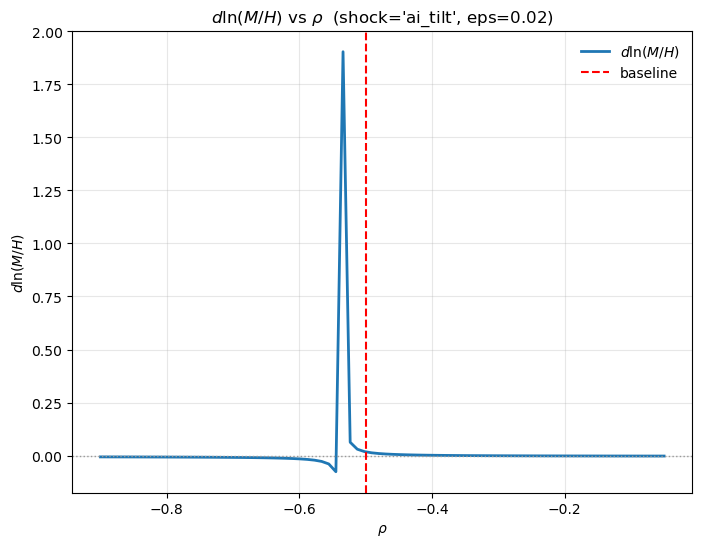

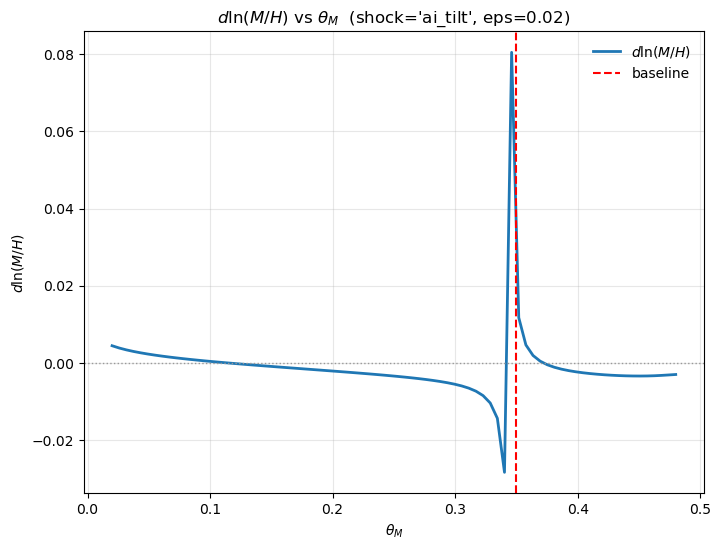

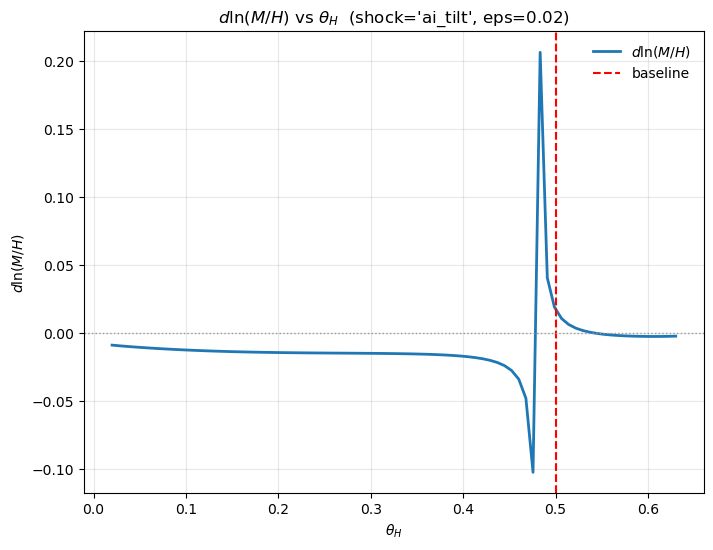

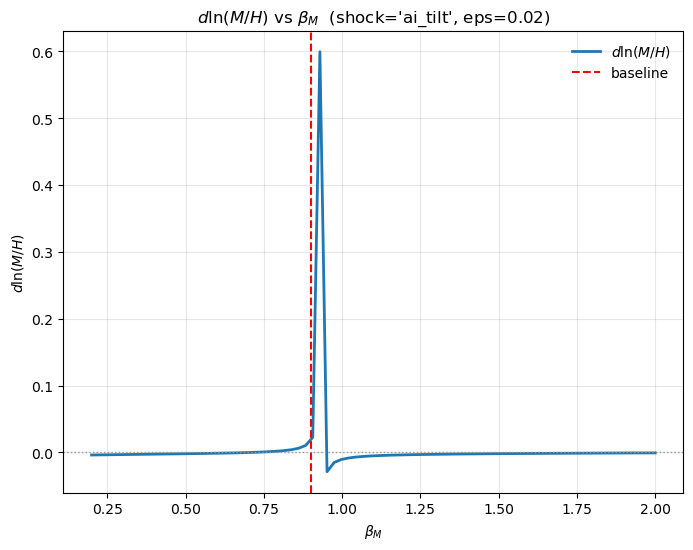

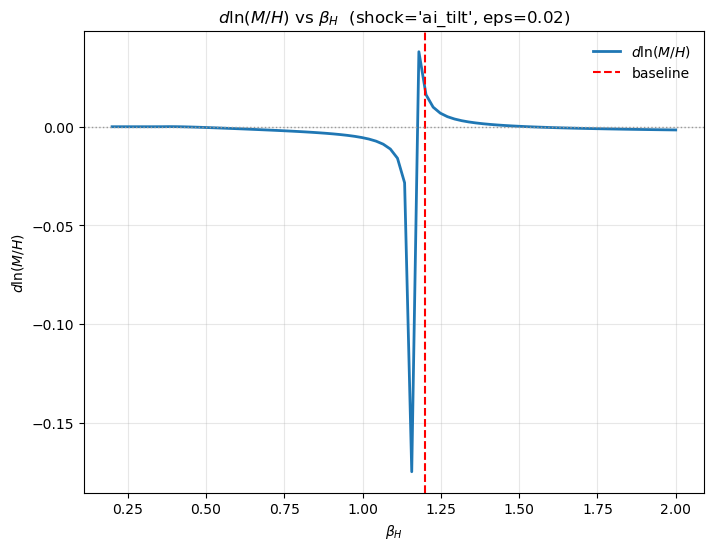

In [ ]:
# step3_plots_separate_with_baseline.py
import numpy as np
import matplotlib.pyplot as plt
import math

# ---- baseline primitives (tweak as needed) ----
p0 = Params(
    beta_H=1.2, beta_M=0.9,
    theta_H=0.50, theta_M=0.35,
    rho=-0.5,
    tau_H=1.1, tau_M=0.8
)

# ---- shock config ----
shock = "ai_tilt"   # "ai_tilt" or "scale"
eps   = 0.02
eta   = 0         # only used for ai_tilt
dln_tauM = 0.0
dln_tauH = 0.0
Nint = 4000

def make_dphi(p):
    return (
        make_delta_phi_ai_tilt(p, eps=eps, eta=eta)
        if shock == "ai_tilt" else
        make_delta_phi_scale(p, eps=eps)
    )

# ---- helpers ----
def is_valid_params(p: Params) -> bool:
    try:
        if not (-1.0 < p.rho < 0.0): return False
        if p.theta_H <= 0 or p.theta_M <= 0: return False
        if p.theta_H + p.theta_M >= 1.0: return False
        if p.beta_H <= 0 or p.beta_M <= 0 or p.tau_H <= 0 or p.tau_M <= 0: return False
        if 1.0 - p.theta_H * (p.tau_H ** p.rho) <= 0.0: return False  # Γ support
    except Exception:
        return False
    return True

def dlnMH_for(p: Params) -> float:
    if not is_valid_params(p):
        return np.nan
    try:
        base = compute_baseline(p)  # mix -> scale betas so cutoff holds
        dphi = make_dphi(p)
        coeffs = step3_coeffs(p, base, dphi, dln_tauM=dln_tauM, dln_tauH=dln_tauH, Nint=Nint)
        out = solve_dlogs_general(p, coeffs)
        return float(out["dlnMH"])
    except Exception:
        return np.nan

def sweep(var_name: str, grid: np.ndarray, p_base: Params):
    xs, ys = [], []
    for x in grid:
        p = Params(**p_base.__dict__)
        setattr(p, var_name, float(x))
        # keep θ_M + θ_H < 1 while sweeping either one
        if var_name in ("theta_M", "theta_H") and (p.theta_M + p.theta_H >= 0.999):
            xs.append(x); ys.append(np.nan); continue
        ys.append(dlnMH_for(p))
        xs.append(x)
    return np.array(xs), np.array(ys)

def plot_one(var_name: str, grid: np.ndarray, p_base: Params, xlabel: str, fname: str = None):
    xs, ys = sweep(var_name, grid, p_base)
    m = np.isfinite(ys)
    baseline_x = getattr(p_base, var_name)

    plt.figure(figsize=(8, 6))
    plt.plot(xs[m], ys[m], lw=2, label=r"$d\ln(M/H)$")
    # baseline vertical line
    plt.axvline(baseline_x, color="red", ls="--", lw=1.5, label="baseline")
    plt.axhline(0.0, color="#999", lw=1, ls=":")
    plt.xlabel(xlabel)
    plt.ylabel(r"$d\ln(M/H)$")
    plt.grid(True, alpha=0.3)
    plt.title(rf"$d\ln(M/H)$ vs {xlabel}  (shock='{shock}', eps={eps})")
    plt.legend(loc="best", frameon=False)
    # if fname:
    #     plt.savefig(fname, bbox_inches="tight", dpi=160)
    plt.show()

# ---- grids (safe ranges) ----
rho_grid    = np.linspace(-0.9, -0.05, 80)

thetaM_hi   = max(0.051, 1.0 - p0.theta_H - 0.02)
thetaM_grid = np.linspace(0.02, thetaM_hi, 80)

thetaH_hi   = max(0.051, 1.0 - p0.theta_M - 0.02)
thetaH_grid = np.linspace(0.02, thetaH_hi, 80)

betaM_grid  = np.linspace(0.2, 2.0, 80)
betaH_grid  = np.linspace(0.2, 2.0, 80)

# ---- make the five separate plots (also saved to PNGs) ----
plot_one("rho",     rho_grid,    p0, r"$\rho$",      "dlnMH_vs_rho.png")
plot_one("theta_M", thetaM_grid, p0, r"$\theta_M$",  "dlnMH_vs_thetaM.png")
plot_one("theta_H", thetaH_grid, p0, r"$\theta_H$",  "dlnMH_vs_thetaH.png")
plot_one("beta_M",  betaM_grid,  p0, r"$\beta_M$",   "dlnMH_vs_betaM.png")
plot_one("beta_H",  betaH_grid,  p0, r"$\beta_H$",   "dlnMH_vs_betaH.png")